In [ ]:
import os, sys
# Add repo root so Python sees models/ & util/
repo_root = os.path.abspath(".")
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

print("🛠 Repo root added:", repo_root)
print("models folder exists:", os.path.isdir(os.path.join(repo_root, "models")))
print("GroundingDINO folder exists:", os.path.isdir(os.path.join(repo_root, "models", "GroundingDINO")))
print("GroundingDINO files:", os.listdir(os.path.join(repo_root, "models", "GroundingDINO")))

from models import build_groundingdino
print("✅ Imported build_groundingdino successfully")


🛠 Repo root added: /isis/home/hasana3/Open-GroundingDino
models folder exists: True
GroundingDINO folder exists: True
GroundingDINO files: ['csrc', 'utils.py', 'backbone', '__pycache__', 'transformer.py', 'ms_deform_attn.py', 'bertwarper.py', 'ops', 'matcher.py', '__init__.py', 'transformer_vanilla.py', 'groundingdino.py', 'fuse_modules.py']
✅ Imported build_groundingdino successfully


/isis/home/hasana3/miniconda3/envs/dino_train/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [10]:
import os
import torch
from util.slconfig import SLConfig
from util.utils import clean_state_dict, to_device
from models import build_model
from models.GroundingDINO import build_groundingdino


def build_model(args):
    return build_groundingdino(args)

# --- 1️⃣  Config & pretrained weight paths ---
cfg_path = "config/GroundingDINO_SwinB_cfg.py"
pretrain_path = "../vlmtest/GroundingDINO/weights/groundingdino_swinb_cogcoor.pth"

# --- 2️⃣  Load config ---
args = SLConfig.fromfile(cfg_path)
args.device = "cuda" if torch.cuda.is_available() else "cpu"

args.use_coco_eval = False     # skip COCO API dependency
args.coco_val_path = None      # prevent missing attribute error


# --- 3️⃣  Build model & criterion ---
model, criterion, postprocessors = build_model(args)
print("✅ Model + Criterion built")

# --- 4️⃣  Load pretrained weights (ignore missing keys safely) ---
if os.path.exists(pretrain_path):
    ckpt = torch.load(pretrain_path, map_location="cpu")
    if "model" in ckpt:
        model.load_state_dict(clean_state_dict(ckpt["model"]), strict=False)
    else:
        model.load_state_dict(clean_state_dict(ckpt), strict=False)
    print(f"✅ Loaded pretrained weights from {pretrain_path}")
else:
    print("⚠️ Pretrained weights not found — continuing without them.")

model = model.to(args.device)
criterion = criterion.to(args.device)
model.eval()


final text_encoder_type: bert-base-uncased
load tokenizer done.
final text_encoder_type: bert-base-uncased
load tokenizer done.
✅ Model + Criterion built
✅ Loaded pretrained weights from ../vlmtest/GroundingDINO/weights/groundingdino_swinb_cogcoor.pth


GroundingDINO(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): DeformableTransformerEncoderLayer(
          (self_attn): MultiScaleDeformableAttention(
            (sampling_offsets): Linear(in_features=256, out_features=256, bias=True)
            (attention_weights): Linear(in_features=256, out_features=128, bias=True)
            (value_proj): Linear(in_features=256, out_features=256, bias=True)
            (output_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (dropout1): Dropout(p=0.0, inplace=False)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout2): Dropout(p=0.0, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (dropout3): Dropout(p=0.0, inplace=False)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=Tr

In [11]:
from util.misc import NestedTensor

# --- Dummy batch (1 image, 384×384 RGB) ---
images = torch.rand(1, 3, 384, 384).to(args.device)
masks = torch.zeros(1, 384, 384, dtype=torch.bool).to(args.device)
samples = NestedTensor(images, masks)

# --- Captions ---
captions = ["car . pedestrian ."]
cap_list = [["car", "pedestrian"]]

# --- Fake GT targets ---
targets = [{
    "boxes": torch.tensor([[0.2, 0.3, 0.4, 0.5]], device=args.device),  # xywh normalized
    "labels": torch.tensor([1], device=args.device),
    "orig_size": torch.tensor([384, 384], device=args.device)
}]

# --- Forward + loss ---
with torch.no_grad():
    outputs = model(samples, captions=captions)
    loss_dict = criterion(outputs, targets, cap_list, captions)

print("🔍 Loss keys:", list(loss_dict.keys()))

for k, v in loss_dict.items():
    if torch.is_tensor(v):
        print(f"{k:25s} : {v.item():.6f}")

# --- Weighted total ---
losses = sum(
    loss_dict[k] * criterion.weight_dict[k]
    for k in loss_dict.keys()
    if k in criterion.weight_dict
)
print("\n🧮 Total weighted loss:", losses.item())

# --- Check any missing/misaligned terms ---
missing_keys = [k for k in loss_dict if k not in criterion.weight_dict]
extra_keys = [k for k in criterion.weight_dict if k not in loss_dict]
print("\n❓Missing in weight_dict:", missing_keys)
print("❓Extra in weight_dict:", extra_keys)


/isis/home/hasana3/miniconda3/envs/dino_train/lib/python3.10/site-packages/transformers/modeling_utils.py:962: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


🔍 Loss keys: ['loss_ce', 'loss_bbox', 'loss_giou', 'loss_xy', 'loss_hw', 'loss_ce_0', 'loss_bbox_0', 'loss_giou_0', 'loss_xy_0', 'loss_hw_0', 'loss_ce_1', 'loss_bbox_1', 'loss_giou_1', 'loss_xy_1', 'loss_hw_1', 'loss_ce_2', 'loss_bbox_2', 'loss_giou_2', 'loss_xy_2', 'loss_hw_2', 'loss_ce_3', 'loss_bbox_3', 'loss_giou_3', 'loss_xy_3', 'loss_hw_3', 'loss_ce_4', 'loss_bbox_4', 'loss_giou_4', 'loss_xy_4', 'loss_hw_4', 'loss_ce_interm', 'loss_bbox_interm', 'loss_giou_interm', 'loss_xy_interm', 'loss_hw_interm']
loss_ce                   : 0.866376
loss_bbox                 : 0.135555
loss_giou                 : 0.208315
loss_xy                   : 0.024464
loss_hw                   : 0.111091
loss_ce_0                 : 0.967588
loss_bbox_0               : 0.089491
loss_giou_0               : 0.142572
loss_xy_0                 : 0.010581
loss_hw_0                 : 0.078910
loss_ce_1                 : 1.018577
loss_bbox_1               : 0.080337
loss_giou_1               : 0.115336
loss_xy

/isis/home/hasana3/miniconda3/envs/dino_train/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


In [12]:
# Gradient check (dry run)
for p in model.parameters():
    if p.grad is not None:
        p.grad.zero_()

images.requires_grad_()  # enable gradient tracking

outputs = model(samples, captions=captions)
loss_dict = criterion(outputs, targets, cap_list, captions)
loss = sum(loss_dict[k] * criterion.weight_dict.get(k, 0.0) for k in loss_dict)
loss.backward()

for name, param in model.named_parameters():
    if param.grad is not None and torch.isnan(param.grad).any():
        print(f"❌ NaN gradient in {name}")
    elif param.grad is not None:
        print(f"{name:60s} grad mean: {param.grad.mean().item():.3e}")
        break  # just sample a few


transformer.level_embed                                      grad mean: -2.228e-03


In [13]:
from datasets import build_dataset
from torch.utils.data import DataLoader


In [18]:
import json
from datasets import build_dataset
from torch.utils.data import DataLoader

# --- 1️⃣ Load the JSON ---
with open("dataset_meta_kitti.json", "r") as f:
    dataset_meta = json.load(f)

# Pick the training dataset (first element of the list)
datasetinfo = dataset_meta["train"][0]
print("Dataset mode:", datasetinfo["dataset_mode"])

args.fix_size = None  # or False if the dataset code expects a boolean


# --- 2️⃣ Build the dataset ---
dataset = build_dataset("train", args, datasetinfo)
print("✅ Dataset built successfully with", len(dataset), "samples")

# --- 3️⃣ Build DataLoader ---
data_loader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=False,
    num_workers=2,
    collate_fn=lambda x: list(zip(*x))
)
print("✅ DataLoader ready.")


Dataset mode: odvg
../vlmtest/GroundingDINO/dataset/kitti/training/image_02 ../vlmtest/GroundingDINO/dataset/kitti/training/train_grounding_fixed.jsonl None
  == total images: 4520
✅ Dataset built successfully with 4520 samples
✅ DataLoader ready.


In [19]:
samples, targets = next(iter(data_loader))

print("Number of samples in batch:", len(samples))
print("Example caption:", targets[0]["caption"])
print("Caption tokens:", targets[0]["cap_list"])
print("GT boxes shape:", targets[0]["boxes"].shape)
print("GT labels:", targets[0]["labels"])


Number of samples in batch: 2
Example caption: pedestrian . car .
Caption tokens: ['pedestrian', 'car']
GT boxes shape: torch.Size([1, 4])
GT labels: tensor([1])


KeyError: 'orig_size'

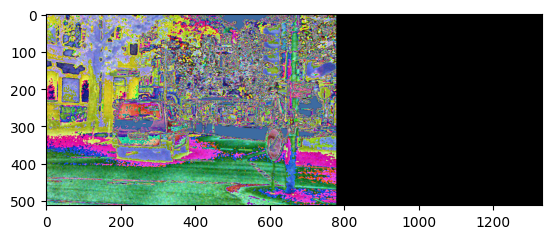

In [21]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

from util.misc import nested_tensor_from_tensor_list

# Unpack batch (tuple -> list)
images_list, targets = samples, targets

# Stack into NestedTensor
samples = nested_tensor_from_tensor_list(images_list).to(args.device)


img_tensor = samples.tensors[0].cpu()
img = F.to_pil_image(img_tensor)
plt.imshow(img)

# draw GT boxes (they are normalized xywh)
boxes = targets[0]["boxes"].cpu().clone()
H, W = targets[0]["orig_size"]
boxes[:, 0] *= W
boxes[:, 1] *= H
boxes[:, 2] *= W
boxes[:, 3] *= H

for (x, y, w, h) in boxes:
    plt.gca().add_patch(plt.Rectangle((x, y), w, h, fill=False, color='lime', lw=2))
plt.title(targets[0]["caption"])
plt.show()


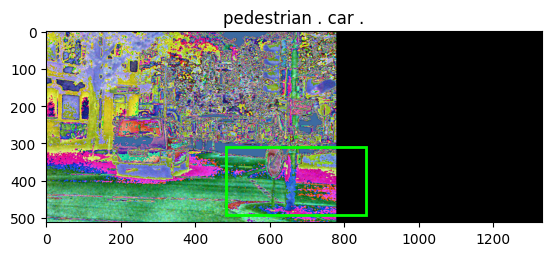

In [22]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

img_tensor = samples.tensors[0].cpu()
img = F.to_pil_image(img_tensor)
plt.imshow(img)

# draw GT boxes (they are normalized xywh)
boxes = targets[0]["boxes"].cpu().clone()
H, W = samples.tensors.shape[2:]
boxes[:, 0] *= W
boxes[:, 1] *= H
boxes[:, 2] *= W
boxes[:, 3] *= H

for (x, y, w, h) in boxes:
    plt.gca().add_patch(plt.Rectangle((x, y), w, h, fill=False, color='lime', lw=2))
plt.title(targets[0].get("caption", ""))
plt.show()


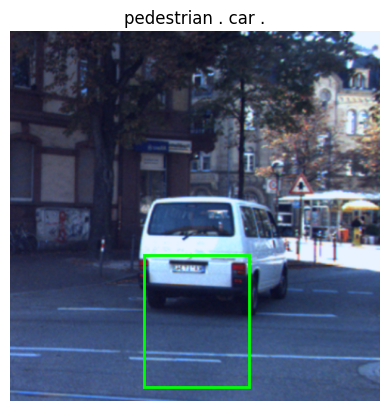

In [23]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

def visualize_sample(samples, targets, idx=0):
    # get single image and mask
    img_tensor = samples.tensors[idx].cpu()
    mask = samples.mask[idx].cpu()

    # unnormalize to [0,1] range if it’s mean/std normalized
    img = img_tensor.clone()
    if img.max() > 1.0 or img.min() < 0.0:
        img = (img - img.min()) / (img.max() - img.min())

    # crop out padded area using the mask
    if mask is not None:
        h, w = (~mask).sum(1).max(), (~mask).sum(0).max()
        img = img[:, :h, :w]

    # convert to PIL for plotting
    pil_img = F.to_pil_image(img)
    plt.imshow(pil_img)

    # draw GT boxes (they are normalized xywh)
    boxes = targets[idx]["boxes"].cpu().clone()
    H, W = img.shape[1:]
    boxes[:, 0] *= W
    boxes[:, 1] *= H
    boxes[:, 2] *= W
    boxes[:, 3] *= H

    for (x, y, w, h) in boxes:
        plt.gca().add_patch(plt.Rectangle((x, y), w, h, fill=False, color='lime', lw=2))
    
    plt.title(targets[idx].get("caption", ""))
    plt.axis("off")
    plt.show()

# ✅ Now call it:
visualize_sample(samples, targets, idx=0)


In [ ]:
from util.misc import nested_tensor_from_tensor_list

# samples is still a tuple of images here
samples_list, targets = next(iter(data_loader))

# Convert tuple → NestedTensor
samples = nested_tensor_from_tensor_list(samples_list)

# Now move it to device
samples = samples.to(args.device)

# Extract captions + cap lists
captions = [t["caption"] for t in targets]
cap_list = [t["cap_list"] for t in targets]

# Move tensor parts of targets to device
targets = [
    {k: v.to(args.device) for k, v in t.items() if torch.is_tensor(v)}
    for t in targets
]

# --- Forward + Loss ---
with torch.no_grad():
    outputs = model(samples, captions=captions)

    # Copy bbox weights to xy/hw terms
    for k, v in list(criterion.weight_dict.items()):
        if k.startswith("loss_bbox"):
            criterion.weight_dict[k.replace("bbox", "xy")] = v
            criterion.weight_dict[k.replace("bbox", "hw")] = v

    loss_dict = criterion(outputs, targets, cap_list, captions)

# --- Print losses ---
print("🔍 Loss keys:", list(loss_dict.keys()))
for k, v in loss_dict.items():
    if torch.is_tensor(v):
        print(f"{k:25s}: {v.item():.6f}")

# --- Weighted total ---
losses = sum(
    loss_dict[k] * criterion.weight_dict[k]
    for k in loss_dict.keys()
    if k in criterion.weight_dict
)
print("\n🧮 Total weighted loss:", losses.item())

# --- Consistency check ---
missing_keys = [k for k in loss_dict if k not in criterion.weight_dict]
extra_keys = [k for k in criterion.weight_dict if k not in loss_dict]
print("\n❓Missing in weight_dict:", missing_keys)
print("❓Extra in weight_dict:", extra_keys)

🔍 Loss keys: ['loss_ce', 'loss_bbox', 'loss_giou', 'loss_xy', 'loss_hw', 'loss_ce_0', 'loss_bbox_0', 'loss_giou_0', 'loss_xy_0', 'loss_hw_0', 'loss_ce_1', 'loss_bbox_1', 'loss_giou_1', 'loss_xy_1', 'loss_hw_1', 'loss_ce_2', 'loss_bbox_2', 'loss_giou_2', 'loss_xy_2', 'loss_hw_2', 'loss_ce_3', 'loss_bbox_3', 'loss_giou_3', 'loss_xy_3', 'loss_hw_3', 'loss_ce_4', 'loss_bbox_4', 'loss_giou_4', 'loss_xy_4', 'loss_hw_4', 'loss_ce_interm', 'loss_bbox_interm', 'loss_giou_interm', 'loss_xy_interm', 'loss_hw_interm']
loss_ce                  : 0.058814
loss_bbox                : 0.083112
loss_giou                : 0.252230
loss_xy                  : 0.009902
loss_hw                  : 0.073210
loss_ce_0                : 0.319229
loss_bbox_0              : 0.048653
loss_giou_0              : 0.148536
loss_xy_0                : 0.010244
loss_hw_0                : 0.038409
loss_ce_1                : 0.394332
loss_bbox_1              : 0.048170
loss_giou_1              : 0.152328
loss_xy_1           

In [27]:
samples, targets = next(iter(data_loader))
print(targets[0].keys())


dict_keys(['size', 'cap_list', 'caption', 'boxes', 'labels'])


In [35]:
# --- 1️⃣ Optimizer & GradScaler ---
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.05)
scaler = torch.cuda.amp.GradScaler(enabled=False)

model.train()
criterion.train()

# --- 2️⃣ Forward + Backward ---
optimizer.zero_grad()
with torch.cuda.amp.autocast(enabled=False):
    outputs = model(samples, captions=captions)
    loss_dict = criterion(outputs, targets, cap_list, captions)

    # Weighted loss
    total_loss = sum(
        loss_dict[k] * criterion.weight_dict[k]
        for k in loss_dict.keys()
        if k in criterion.weight_dict
    )

# --- 3️⃣ Backprop + Step ---
scaler.scale(total_loss).backward()
scaler.step(optimizer)
scaler.update()

# --- 4️⃣ Inspect gradient norms ---
grad_norm = 0.0
for n, p in model.named_parameters():
    if p.grad is not None:
        grad_norm += p.grad.data.norm(2).item()
print(f"🧮 One-batch grad norm: {grad_norm:.3f}")
print(f"✅ Single-batch update done (loss={total_loss.item():.4f})")


/isis/home/hasana3/miniconda3/envs/dino_train/lib/python3.10/site-packages/transformers/modeling_utils.py:962: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


🧮 One-batch grad norm: 1242.790
✅ Single-batch update done (loss=9.9202)


In [39]:
import numpy as np
from tqdm import tqdm

model.train()
losses = []

for i, (samples_list, targets) in enumerate(tqdm(data_loader, total=10)):
    if i >= 10:
        break
    samples = nested_tensor_from_tensor_list(samples_list).to(args.device)
    captions = [t["caption"] for t in targets]
    cap_list = [t["cap_list"] for t in targets]
    targets = [{k: v.to(args.device) for k, v in t.items() if torch.is_tensor(v)} for t in targets]

    optimizer.zero_grad()
    outputs = model(samples, captions=captions)
    loss_dict = criterion(outputs, targets, cap_list, captions)
    total_loss = sum(loss_dict[k] * criterion.weight_dict[k] for k in loss_dict if k in criterion.weight_dict)
    total_loss.backward()
    optimizer.step()

    losses.append(total_loss.item())
    print(f"Batch {i}: loss={total_loss.item():.4f}")

print(f"\n📉 Mean loss over 10 batches: {np.mean(losses):.4f}")


 10%|█         | 1/10 [00:01<00:11,  1.23s/it]

Batch 0: loss=6.4161


 20%|██        | 2/10 [00:01<00:07,  1.12it/s]

Batch 1: loss=7.2295


 30%|███       | 3/10 [00:02<00:05,  1.20it/s]

Batch 2: loss=11.7551


 40%|████      | 4/10 [00:03<00:04,  1.26it/s]

Batch 3: loss=7.8508


 50%|█████     | 5/10 [00:03<00:03,  1.45it/s]

Batch 4: loss=8.6800


 60%|██████    | 6/10 [00:04<00:02,  1.39it/s]

Batch 5: loss=3.5830


 70%|███████   | 7/10 [00:05<00:02,  1.35it/s]

Batch 6: loss=6.2835


 80%|████████  | 8/10 [00:06<00:01,  1.37it/s]

Batch 7: loss=6.3456


 90%|█████████ | 9/10 [00:06<00:00,  1.38it/s]

Batch 8: loss=4.8641


100%|██████████| 10/10 [00:07<00:00,  1.30it/s]

Batch 9: loss=3.2326


100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


📉 Mean loss over 10 batches: 6.6240


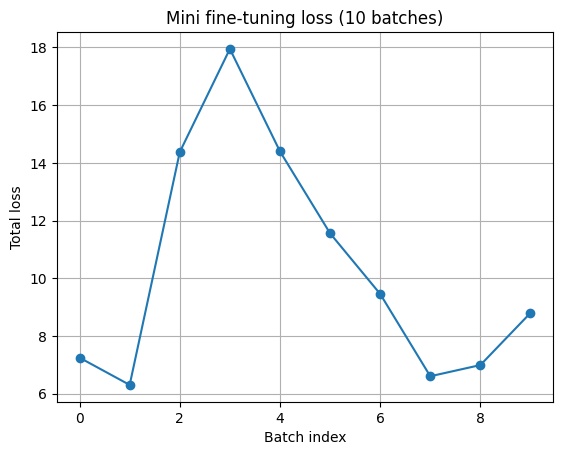

In [37]:
import matplotlib.pyplot as plt
plt.plot(losses, marker='o')
plt.title("Mini fine-tuning loss (10 batches)")
plt.xlabel("Batch index")
plt.ylabel("Total loss")
plt.grid(True)
plt.show()
